In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold 
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, roc_auc_score

from sklearn.ensemble import RandomForestRegressor

import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Класс модели Gradient Boosting (на решающих деревьях)

In [3]:
# Определение класса градиентного бустинга
class GradientBoosting():
    
    def __init__(self, eta=0.5, n_estimators=10, min_data_in_leaf=5, max_depth=10, random_state=42, model_type='regression', coefs=[], n_batches=1, split_points=-1):
        
        coefs = coefs if len(coefs) > 0 else np.linspace(1, 0.5, n_estimators+1)
        
        self.X_train = []                        # обучающие данные
        self.y_train = []                        # обучающие классы
        self.n_estimators = n_estimators         # кол-во решающих деревьев
        self.min_data_in_leaf = min_data_in_leaf # минимальное кол-во данных в терминаьном листе
        self.max_depth = max_depth               # максимальная глубина дерева
        self.eta = eta                           # learning rate
        self.coefs = coefs                       # коэфициенты при алгоритмах/деревья
        self.random_state = random_state         # random_state
        self.model_type = model_type             # тип предсказания 'Classificator', 'Regressor'
        self.forest = []                         # список корней решающих деревьев (по сути решающих деревьев)
        self.train_err = []                      # список ошибок на каждом из этапов тренировки
        self.valid_err = []                      # список ошибок валидационного датасета на каждом из этапов тренировки
        self.n_batches = n_batches               # кол-во частей для разбивки датасета для стахастического градиентного бустинга
        self.split_points = split_points         # Кол-во точек разделения данных при построении ветвей (-1 - максимально возможное)
        self.train_pred = []                     # Сохранение предсказания для ускорения алгоритма
        self.valid_pred = []                     # Сохранение предсказания для ускорения алгоритма 
        
    # Класс узла дерева
    class Node:

        def __init__(self, index, t, left_branch, right_branch, depth=0):
            self.index = index               # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t                       # значение порога
            self.left_branch = left_branch   # поддерево, меньше порогового значения t (левая ветка)
            self.right_branch = right_branch # поддерево, больше порогового значения t (правая ветка)
            self.depth = depth               # глубина 
    
        # Функция предсказания для отдельного объекта
        def obj_predict(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict(obj)
            else:
                return self.right_branch.obj_predict(obj)
        
        def obj_predict_proba(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict_proba(obj)
            else:
                return self.right_branch.obj_predict_proba(obj)         
        
        # Функция формирования предсказания по выборке на одном дереве
        def predict(self, data):
            return np.array([self.obj_predict(obj) for obj in np.array(data)])
                
        def predict_proba(self, data):          
            return np.array([self.obj_predict_proba(obj) for obj in np.array(data)])
        
    
    # Класс терминального листа
    class Leaf:
        def __init__(self, data, labels, depth, model_type):
            self.data = data
            self.labels = labels
            self.depth = depth
            self.model_type = model_type # тип предсказания 'Classificator', 'Regressor'
            self.prediction = self.obj_predict()
        
        def obj_predict(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count)
            if self.model_type == 'regression':
                return np.mean(self.labels)
            
            return np.zeros(len(self.labels))
        
        def obj_predict_proba(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count) / self.labels.shape[0]
            if self.model_type == 'regression':
                return np.zeros(self.labels.shape[0])
        
    # Построение дерева с помощью рекурсивной функции
    def create_tree(self, data, labels, depth=0):

        # выбор индекса из случайной подвыборки длиной sqrt(n_features)
        if self.model_type == 'classification':
            index_qty = int(np.sqrt(data.shape[1]))
        if self.model_type == 'regression':
            index_qty = max( int(round(np.sqrt(data.shape[1]),0)) , int(data.shape[1] / 3))
        
        # Построение дерева на всех признаках (только для случая GB)
        
        index_list = np.random.choice(range(data.shape[1]), index_qty+1, replace=False)
        quality, t, index = self.best_split(data, labels, index_list)
        
        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == float('Inf') or depth == self.max_depth:
            return self.Leaf(data, labels, depth, self.model_type)

        data_left, data_right, labels_left, labels_right = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        branch_left = self.create_tree(data_left, labels_left, depth + 1)
        branch_right = self.create_tree(data_right, labels_right, depth + 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, branch_left, branch_right, depth)
    
    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
        left = (data[:, index] <= t)
        right = (data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]    

    
    # Расчет качества разбиения (чем меньше значение функции, тем лучше)
    def split_criteria(self, left_labels, right_labels):
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        gini = lambda y: (1 - sum((np.unique(y, return_counts=True)[1] / len(y))**2))
        
        p = len(left_labels) / (len(left_labels) + len(right_labels))
        
        if self.model_type == 'Regressor':
            # Сумма среднеквадратичных отклонений по левой и правой выборке
            return p * (np.std(left_labels) ** 2)  + (np.std(right_labels) ** 2) * (1-p)
        else:
            # Доля выборки, ушедшая в левое поддерево

            # Расчет криетрия jini
            return (p * gini(left_labels) + (1 - p) * gini(right_labels))
    
    # Нахождение наилучшего разбиения
    def best_split(self, data, labels, index_list):            
        
        # формулы расчета критериев качества разбиения
        gini = lambda labels: (1 - sum((np.unique(labels, return_counts=True)[1] / len(labels))**2))
        gini_criteria = lambda p, left_labels, right_labels: p * gini(left_labels) + (1 - p) * gini(right_labels)
        mse_criteria = lambda p, left_labels, right_labels: p * np.var(left_labels)  + np.var(right_labels) * (1-p)       
        
        best_quality, best_t, best_index = float('Inf'), None, None
        
        #Перебор вариантов разбиения данных для построения дерева 
        for index in index_list:
            # определение точек для проверки при разбиении данных на ветви
            if self.split_points == -1:
                split_points = np.unique(data[:,index])
            else:
                split_points = np.unique(np.quantile(data[:,index], np.linspace(0, 1, self.split_points+1)))
            
            for t in split_points:      
                left_data, right_data, left_labels, right_labels = self.split(data, labels, index, t)
                
                # рассматриваем только те разбиения, в которых в узлах остается не менее min_data_in_leaf объектов
                if len(left_data) >= self.min_data_in_leaf and len(right_data) >= self.min_data_in_leaf:
                    p = len(left_labels) / (len(left_labels) + len(right_labels))
                    # Расчет Критерия качества разбиения
                    if self.model_type == 'regression':
                        cur_quality = p * np.var(left_labels)  + np.var(right_labels) * (1-p)
                    if self.model_type == 'classification':
                        cur_quality = p * gini(left_labels) + (1 - p) * gini(right_labels)                
                    
                    #  Определяем разбиение с лучшим качеством                
                    if cur_quality <  best_quality:
                        best_quality, best_t, best_index = cur_quality, t, index

        return best_quality, best_t, best_index
    
    
    # Построение леса
    def fit(self, X_train, y_train, X_valid=[], y_valid=[]):
        
        self.forest = []
        X_train = X_train.values
        y_train = y_train.values
        self.X_train = X_train
        self.y_train = y_train
        
        N = X_train.shape[0]
        batch_size = N // self.n_batches
        
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        
        # Определение метода расчета сдвига
        if self.model_type == 'regression':
            bias = lambda y, z: y - z
        if self.model_type == 'classification':
            bias = lambda y, z: -y / (1+np.exp(-y*z))
        
        np.random.seed(self.random_state)
        
        
        # первый алгоритм просто обучаем на выборке и добавляем в список
        tree = self.create_tree(X_train, y_train)
        self.forest.append(tree)
                
        y_train_pred = self.predict(X_train)
        y_valid_pred = self.predict(X_valid)
                
        self.train_pred.append(y_train_pred)
        self.valid_pred.append(y_valid_pred)
                
        self.train_err.append(mse_err(y_train, y_train_pred))
        self.valid_err.append(mse_err(y_valid, y_valid_pred))
                
        tree_mse_err = np.round(np.sqrt(mse_err(y_valid, y_valid_pred)),3)
                
        best_tree_mse_err = tree_mse_err
        best_tree = 0
                
        print('\r'*200, 'Best tree #:', best_tree, '     Best MSE:', best_tree_mse_err, '          Cur tree #:', 0, '     Cur MSE:', tree_mse_err, end='')
        
        
        # алгоритмы начиная со второго обучаются на сдвиг
        for i in range(1, self.n_estimators):
            tree = self.create_tree(X_train, bias(y_train, self.train_pred[-1]))
            
            self.forest.append(tree)
                    
            self.train_pred.append(self.train_pred[-1] + self.forest[-1].predict(X_train) * self.coefs[i] * self.eta)
            self.valid_pred.append(self.valid_pred[-1] + self.forest[-1].predict(X_valid) * self.coefs[i] * self.eta)
            
            y_train_pred = self.train_pred[-1]
            y_valid_pred = self.valid_pred[-1]
                    
            self.train_err.append(mse_err(y_train, y_train_pred))
            self.valid_err.append(mse_err(y_valid, y_valid_pred))
                    
            tree_mse_err = np.round(np.sqrt(mse_err(y_valid, y_valid_pred)),3)
            
            if tree_mse_err < best_tree_mse_err:
                best_tree_mse_err = tree_mse_err
                best_tree = i
            print('\r'*300, ' ' * 300, '\r'*300 + '', end='')
            print('\r'*200, 'Best tree #:', best_tree, '     Best MSE:', best_tree_mse_err, '          Cur tree #:', i, '     Cur MSE:', tree_mse_err, end='')        
                    
        print('\r'*300, ' ' * 300, '\r'*300 + '', end='')
        
        self.forest = self.forest[:best_tree+1]
    
    # Тренеровка модели
    def tain(self, X_train, y_train, X_valid, y_valid):
        self.fit(self, X_train, y_train, X_valid, y_valid)
    
    # предсказание
    def predict(self, data):
        pred = self.forest[0].predict(data)
        for i in range(1,len(self.forest)):
            pred += self.forest[i].predict(data) * self.coefs[i] * self.eta
            
        return pred

# Функции предобработки данных

In [4]:
# Разбивка на фолды стратифицированная по значению целевой переменной
def SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=5, random_state=42):

    # Определение кол-ва слоев
    layers_qty = min(max_layers_qty, np.unique(df[TARGET_NAME]).shape[0])
    # Определение значения целевой переменной для разбивки на слои
    split_points = np.linspace(np.min(df[TARGET_NAME]), np.max(df[TARGET_NAME]), layers_qty+1)
    #split_points = np.quantile(np.sort(np.unique(df[TARGET_NAME])), np.linspace(0, 1, layers_qty+1))
    
    # Формирование списка со значениями индексов слоев и списка содержащего фолды для тренировки и валидации
    layers=[]
    SKF_list = [[np.array([]),np.array([])] for i in range(n_splits)]
    
    np.random.seed(random_state) 
    
    for i in range(len(split_points)-1):
        # Определение индекса элементов входящих в слой
        if i == len(split_points)-2:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]<=split_points[i+1])].index)
        else:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]< split_points[i+1])].index)
    
        np.random.shuffle(layer_index)
        b_qty = layer_index.shape[0] // n_splits

        for j in range(n_splits):
            if j == n_splits - 1:              
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j:]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0:b_qty * j]))
            else:
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j: b_qty * (j+1)]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0: b_qty * j], layer_index[b_qty * (j+1):]))
            
    return SKF_list

In [5]:
# Функция масштабирования данных (аналог StandardScaler и MinMaxScaler)
class scaler():
    
    def __init__(self, scaler_type='std'):
        self.scaler_type = scaler_type
        self.min = 0
        self.max = 0
        self.std = 0
        self.mean = 0
    
    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        self.std = np.std(data, axis=0)
        self.mean = np.mean(data, axis=0)
        return self
        
    def train(self, data):
        fit(self, data)
        
    def transform (self, data):
        if self.scaler_type == 'std':
            return (data - self.mean) / self.std
        
        if self.scaler_type == 'norm':
            return (data - self.mean) / self.std      
        
        if self.scaler_type == 'none':
            return data
    
    def fit_transform(self, data):
        fit(self, data)
        transform (self, data)
        

In [6]:
# Балансировка по целевому классу
def balance_df_by_target(df, TARGET_NAME, portion_of_target_class=0.5, random_state=17, balance_type='add'):
    df_tmp = df.copy()
    counts_0 = (df_tmp[TARGET_NAME] == 0).sum()
    counts_1 = (df_tmp[TARGET_NAME] == 1).sum()
    
    if balance_type == 'add':
        if portion_of_target_class > (counts_1 / (df.shape[0])):
            disbalance = int(counts_0 / (1-portion_of_target_class) - df.shape[0])
            add_class = 1
        else:
            disbalance = int(counts_1 / portion_of_target_class - df.shape[0])
            add_class = 0

        sample = df_tmp[df_tmp[TARGET_NAME] == add_class].sample(n=disbalance, replace=True, random_state=random_state)
        df_tmp = pd.concat([sample, df_tmp], axis=0)
    
    return df_tmp

# Функция расчета метрик и вывод результатов

In [7]:
def short_model_score_report(y_true, y_pred, y_pred_proba, name, header=True, model_type='classification'):
    # отчет для модели классификации
    if model_type == 'classification':
        f1 = round(f1_score(y_true, y_pred),4)
        pr = round(precision_score(y_true, y_pred),4)
        re = round(recall_score(y_true, y_pred),4)
        roc = round(roc_auc_score(y_true, y_pred_proba),4)
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}{:>17}\033[0m'.format('Model', 'f1 score', 'Recall', 'Precission', 'ROC AUC'))
        print('{:<20}{:>12}{:>17}{:>17}{:>17}'.format(name, f1, re, pr, roc))
    
    # отчет для модели регрессии
    mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
    
    if model_type == 'regression':
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        rmse_err = lambda y, y_pred : mse_err(y, y_pred) ** 0.5
        mae_err = lambda y, y_pred : np.mean(np.abs(y - y_pred))
        r2_calc = lambda y, y_pred : 1 - mse_err(y, y_pred) / mse_err(y, np.mean(y))
        
        mae = round(mae_err(y_true, y_pred),4)
        rmse = round(rmse_err(y_true, y_pred),4)
        r2 =  round(r2_calc(y_true, y_pred),4)
        
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}\033[0m'.format('Model', 'MAE', 'RMSE', 'R2'))
        print('{:<20}{:>12}{:>17}{:>17}'.format(name, mae, rmse, r2))

# Функции для исследования данных

In [8]:
def categorization_comparison_by_target_class(df, TARGET_NAME, column, sort_by='class', max_len=50):
    df_tmp = df.copy()
    #col_lst = df_tmp.drop([TARGET_NAME], axis=1).select_dtypes(include=['object']).columns
    col_lst = [column]
    
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_size_inches (20, min(df[column].nunique(), max_len)*0.5)
    plt.subplots_adjust(wspace=0.3)
    ax = ax.flatten()
    ax[1].remove()
    ax[0] = plt.subplot2grid((1,3), (0,0), colspan=2)
    
    for i in range(1):
        col = col_lst[i]
        data = df_tmp.groupby(by=col).agg({TARGET_NAME: [sum, len]})
        data['1'] = data[(TARGET_NAME, 'sum')]
        data['ttl'] = data[(TARGET_NAME, 'len')]
        data['1%'] =  data['1'] / data['ttl']
        data['0%'] =  1 - data['1%']
        data['weight'] = data['ttl'] / df_tmp.shape[0]
        if sort_by=='class':
            data = data.sort_values(by=['1%'])
        elif sort_by=='weight':
            data = data.sort_values(by=['weight'])
        elif sort_by=='label':  
            data = data.sort_index()
        
        data = data.iloc[max(data.shape[0] - max_len,0):,:]
        
        ax[0].barh(range(data.shape[0]), data['0%'], label='0')
        ax[0].barh(range(data.shape[0]), data['1%'], label='1', left=data['0%'])    
        ax[0].set_xlabel('Portion of class, %')
        ax[0].set_title('Target distribution by "' + col + '"')
        ax[0].set_xticks(np.linspace(0, 1, 11))
        
        ax[0].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['1%'] * 100, 1)).astype('str') + '%\n' + data.index.astype('str')
        ax[0].set_yticklabels(y_ticks)

        ax[0].legend(title=TARGET_NAME)
        ax[0].axvline(df_tmp.loc[df_tmp[TARGET_NAME]==0].shape[0] / df_tmp.shape[0], c='r')
        
        ax[2].barh(range(data.shape[0]), round(data['ttl'] / df_tmp.shape[0] * 100, 1), label='Weight', height=0.8)
        ax[2].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['ttl'] / df_tmp.shape[0] * 100, 1)).astype('str') + '% - ' + data['ttl'].astype('str') + '\n' + data.index.astype('str')
        ax[2].axvline(100/ df_tmp[column].nunique(), c='r')
        ax[2].set_yticklabels(y_ticks)
        ax[2].legend()

In [9]:
def distribution_comparison_by_target_class(df, TARGET_NAME, model_type='classification'):
    
    ci =95 # confidense interval
    col_lst = list(df.drop(columns=TARGET_NAME).select_dtypes(include=['float64']).columns)

    fig, ax = plt.subplots(nrows=len(col_lst), ncols=3)
    
    fig.set_size_inches (21 , len(col_lst) * 5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    ax = ax.flatten()
    
    
    for i in range(len(col_lst)):
        
        if model_type == 'classification':
            sns.kdeplot(df.loc[df[TARGET_NAME] == 0, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax[i*3])
            sns.kdeplot(df.loc[df[TARGET_NAME] == 1, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax[i*3])
            ax[i*3].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
            ax[i*3].legend()

            sns.pointplot(x=TARGET_NAME, y=col_lst[i], data=df[[TARGET_NAME, col_lst[i]]], capsize=.1, ci=ci, ax=ax[i*3+1]);
            ax[i*3+1].set_title('Confidence intervals ('+ str(ci) + ' %) for ' + col_lst[i])
        
        if model_type == 'regression':
            sns.kdeplot(df[col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label=col_lst[i] + '  density', ax=ax[i*3])
            ax[i*3].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
            ax[i*3].legend()

            ax[i*3+1].scatter(y=df[col_lst[i]], x=df[TARGET_NAME])
            ax[i*3+1].set_title(col_lst[i] + ' by ' + TARGET_NAME)
            

        cor = np.abs(df.corr()[col_lst[i]]).sort_values(ascending=False)[1:]
        sns.barplot(x=cor[:6], y=cor.index[:6], ax=ax[i*3+2])
        ax[i*3+2].set_title('Top cor features (abs)')

In [10]:
#Немного дополненная информация по массиву
def describe(df):
    stat = pd.DataFrame(index=df.columns)
    
    stat['count'] = df.count()
    stat['mean'], stat.loc[df.mean().index, 'mean'] = np.nan, df.mean()
    stat['median'], stat.loc[df.mean().index, 'median'] = np.nan, df.median()
    stat['std'], stat.loc[df.mean().index, 'std'] = np.nan, df.std()
    stat['min'], stat.loc[df.mean().index, 'min'] = np.nan, df.min()
    stat['25%'], stat.loc[df.mean().index, '25%'] = np.nan, df.quantile(0.25)
    stat['50%'], stat.loc[df.mean().index, '50%'] = np.nan, df.quantile(0.5)
    stat['75%'], stat.loc[df.mean().index, '75%'] = np.nan, df.quantile(0.75)
    stat['max'], stat.loc[df.mean().index, 'max'] = np.nan, df.max()
    
    stat['type'] =df.dtypes
    stat['NUnique'] = df.nunique()
    stat['NotNull'] =df.notnull().sum()
    
    return stat

In [11]:
def heatmap(df):
    plt.figure(figsize = (1 * df.shape[1], 0.5 * df.shape[1]))
    sns.set(font_scale=1)
    sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

# Функция валидации моделей

In [12]:
# Функция для валидации модели
# масштабирование данных
# разбивка на фолды
# обучение моделей и сохранение
# расчет предсказаний (валидационный и тетовый датасет) и запись в журнал
# Формирование отчета

def check_models(df=[],                  # датасет
               df_test=[],               # датасет для которого нужно сформировать предсказания
               TARGET_NAME='',           # Имя столбца с целевой переменной
               models = [],              # словарь моделей (обязательно  должны быть методы fit, predict)   
               target_class_ratio=0.5,   # коэффициент для балансровки соотношения классов целевой переменной
               random_state=42,          # Random_State
               SKF_splits=4,             # кол-во фолдов для валидации
               fold_report=True,         # вывод репорта для каждого фолда
               train_report=False,       # вывод отчета для тренировочного датасета
               data_pr=True,             # Обработка данных перед построением модели 
               scaler_type='std',        # Функция масштабирования признаков ('none', 'std', 'norm')
               strat_layers_qty=20,      # Кол-во слоев для стратификации датасета по целевой переменной при применении k-fold
               model_type='classification'): # тип предсказания :  'classification', 'regression'
    
    first_model = list(models.keys())[0]
    
    # Список для сохранения натренированных моеделей
    model_list = []
    
    # Формирование датасетов для записи результатом работы моделей
    df_result = pd.DataFrame({'index': df.index, TARGET_NAME: df[TARGET_NAME]})
    df_test_result = pd.DataFrame({'index': df_test.index})
    
    for i in models.keys():
        df_result[i], df_result[i + '_p'] = float("NaN"), float("NaN")
        df_test_result[i], df_test_result[i + '_p'] = np.zeros(df_test.shape[0]), np.zeros(df_test.shape[0])
    
    #Разбивка на test и train 
    split = 0
    
    skf = SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=20, random_state=42)
    
    for train_index, valid_index in skf:
        split += 1
        
        #Обработка данных функцией и выстраивание одинаковой очередности колонок
        if data_pr:
            df_train_pr = data_processing(df.loc[train_index], df.loc[train_index])
            df_valid_pr = data_processing(df.loc[valid_index], df.loc[train_index])[df_train_pr.columns]
            df_test_pr = data_processing(df_test, df.loc[train_index])[df_train_pr.drop(columns=[TARGET_NAME]).columns]
            
        else:
            df_train_pr = df.loc[train_index].copy()
            df_valid_pr = df.loc[valid_index].copy()
            df_test_pr = df_test.copy()
        
        
        # Масштабирование данных для моделей (критично для линейных моделей)
        df_train_pr_sc = df_train_pr
        df_valid_pr_sc = df_valid_pr
        df_test_pr_sc = df_test_pr

        sc_cols= df_train_pr.drop(columns=TARGET_NAME).select_dtypes(exclude=['O']).columns
        data_scaler = scaler(scaler_type=scaler_type).fit(df_train_pr[sc_cols])
        
        df_train_pr_sc[sc_cols] = data_scaler.transform(df_train_pr[sc_cols])
        df_valid_pr_sc[sc_cols] = data_scaler.transform(df_valid_pr[sc_cols])
        df_test_pr_sc[sc_cols] = data_scaler.transform(df_test_pr[sc_cols])
        
        #Балансировка по целевому классу в случае классификации
        if model_type == 'classification':
            df_train_pr_sc_bl = balance_df_by_target(df_train_pr_sc, 
                                                     TARGET_NAME, 
                                                     target_class_ratio,
                                                     random_state=2)
        
        elif model_type == 'regression':
            df_train_pr_sc_bl = df_train_pr_sc
        
        X_train = df_train_pr_sc_bl.drop(columns=TARGET_NAME)
        y_train = df_train_pr_sc_bl[TARGET_NAME]
        
        X_valid = df_valid_pr_sc.drop(columns=TARGET_NAME)
        y_valid = df_valid_pr_sc[TARGET_NAME]
        
        X_test = df_test_pr_sc

        #Тренировка моделей
        for i in models.keys(): 
            
            if i == 'catbm':
                cat_feat_idx = list(np.where(X_train.dtypes == 'object')[0])
                models[i].fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_feat_idx, plot=False)
            elif i == 'gb':
                models[i].fit(X_train, y_train, X_valid=X_valid, y_valid=y_valid)
            
            else:
                models[i].fit(X_train, y_train)
            
            model_list.append([i, split, models[i]])
        
            # Запись предсказаний моделей в журнал
            y_valid_pred = models[i].predict(X_valid)
            df_result.loc[valid_index, i] = y_valid_pred
            df_test_result[i] += models[i].predict(X_test)
            
            if model_type == 'classification':
                y_valid_pred_proba = models[i].predict_proba(X_valid)[:,1]
                df_result.loc[valid_index, i + '_p'] = y_valid_pred_proba
                df_test_result[i + '_p'] += models[i].predict_proba(X_test)[:,1]
            elif model_type == 'regression':
                y_valid_pred_proba = np.zeros(X_valid.shape[0])
            
            # Формирование и вывод отчета по фолду
            if fold_report:
                if (i == first_model):
                    print('\nFOLD ' + str(split) + ' REPORT')
                
                short_model_score_report(y_valid, 
                                         y_valid_pred, 
                                         y_valid_pred_proba, 
                                         name=i + '_' +str(split) + '_valid', 
                                         header=(i == first_model),
                                         model_type=model_type)
                
                # Расчет и вывод отчета для тренировочных данных
                if train_report:
                    y_train_pred = models[i].predict(X_train).astype('int')
                    y_train_pred_proba = models[i].predict_proba(X_train)[:,1]
                    
                    short_model_score_report(y_train, 
                                             y_train_pred, 
                                             y_train_pred_proba, 
                                             name=len(i + '_' +str(split)) * ' ' + ' train',
                                             model_type=model_type)
                
    #Усреднение предсказаний каждой модели на фолдах
    df_test_result.loc[:,first_model:] = df_test_result.loc[:,first_model:] / SKF_splits 

    # Вывод финального отчета
    print('\nFINAL REPORT ({} folds AVG)'.format(SKF_splits))
    for i in models.keys():
        short_model_score_report(df_result[TARGET_NAME],
                                 df_result[i], df_result[i+'_p'],
                                 name=i,
                                 header=(i == first_model),
                                 model_type=model_type)
    
    y_valid = df[TARGET_NAME]
    y_valid_pred_proba = np.sum(df_result[[i + '_p' for i in models.keys()]],axis=1) / len(models.keys())
    
    if model_type == 'classification':
        y_valid_pred = np.round(y_valid_pred_proba).astype(int)
    elif model_type == 'regression':
        y_valid_pred = np.sum(df_result[[i for i in models.keys()]],axis=1) / len(models.keys())
    
    short_model_score_report(y_valid,
                             y_valid_pred,
                             y_valid_pred_proba,
                             name='MIX RESULT ',
                             header=False,
                             model_type=model_type)
    
    return df_result, df_test_result, model_list

# Функция автоматической обрабтки входных данных

In [18]:
# Функция обработки данных (чистка данных, трансформация и дабавление признаков для тренинровочного и тестового датасетов)
def data_processing(df, df_for_stat):
    
    #функция для чистки выбросов по интерквартильному размаху
    def clean_drop_outs(col, stat_col, span, funciotn):
        max_col_value = stat_col.quantile(q=0.75) + (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        min_col_value = stat_col.quantile(q=0.25) - (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        col.loc[(col > max_col_value) | (col < min_col_value)] = funciotn(stat_col)
    
    #функция замены пустых значений на центральные меры
    def replace_zeros(col, function):
        tmp_df.loc[tmp_df[col].isnull(), col] = function(tmp_df.loc[tmp_df[col]!=0, col])
        

    # Замена категории на частоту по целевому классу
    def replace_with_fr(col):
        fr_dict =  dict(df_for_stat.groupby(by=col).agg({TARGET_NAME:np.mean}).reset_index().values)
        tmp_df[col+'_fr'] = tmp_df[col].map(fr_dict)

    df = df.copy()
    stat = df_for_stat.copy()
    
    # Healthcare_1 - замена пустых значений на моду (сначала заменяются на моды по району, а если такой нет то на моду по датасету)
    hc_med_dict = dict(df.groupby(by='DistrictId')['Healthcare_1'].median().reset_index().values)
    df['Healthcare_1'].fillna(df['Healthcare_1'].median(), inplace=True)
    
    df.loc[df['KitchenSquare']<=4, 'KitchenSquare'] = round(np.mean(df['KitchenSquare']))
    clean_drop_outs(df['KitchenSquare'], stat['KitchenSquare'], 2, np.mean)
    
    clean_drop_outs(df['LifeSquare'], stat['LifeSquare'], 2, np.mean)
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] + df['KitchenSquare']  
    
    df['Ecology_2'] = df['Ecology_2'].map({'A':1, 'B':0})
    df['Ecology_3'] = df['Ecology_3'].map({'A':1, 'B':0})
    df['Shops_2'] = df['Shops_2'].map({'A':1, 'B':0})
    
    # Dummy переменные - вручную (автоматом добавляет 2 переменные, а вручную - 1) 
    df = pd.get_dummies(df)

    
    return df

# Функция для автоматической генерации и проверки признаков

In [13]:
# Генерация новых признаков путем умножения и деления и вывод наиболее корелирующих с целевой переменной
def feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.15, hi_limit=0.15, plot_cor=False, powers=[-1, 2]):  
    
    # Подфункция проверки уровня корреляции и добавления в массив
    def add_hi_cor_feature(col_name, col_values, col_values_test):
        cor = df[[TARGET_NAME]].corrwith(other=col_values)[0]
        if (cor >= hi_limit) or (cor <= lo_limit):
            df_tmp[col_name] = col_values
            df_tmp[col_name] = df_tmp[col_name].fillna(np.mean(col_values))
            df_test_tmp[col_name] = col_values_test
            df_test_tmp[col_name] = df_test_tmp[col_name].fillna(np.mean(col_values_test))
    
    df_tmp=df.drop(columns=TARGET_NAME).copy()
    df_test_tmp = df_test.copy()
    
    num_col_lst = df_tmp.select_dtypes(exclude=['O']).columns
    
    for i in range(len(num_col_lst)):
        # Проверка уровня корреляции признака в разной степени
        for power in powers:
            add_hi_cor_feature(num_col_lst[i] + ' ** (' + str(power) +')', df[num_col_lst[i]].astype('float') ** power, df_test[num_col_lst[i]].astype('float') ** power)
        
        # Проверка уровня корреляции логорифмированного признак                
        add_hi_cor_feature('LOG '+ num_col_lst[i], np.log(df[num_col_lst[i]]), np.log(df_test[num_col_lst[i]]))  
        
        for j in range(len(num_col_lst)):
            # Проверка уровня корреляции результатов деления признаков
            if i != j:
                col_name = num_col_lst[j] +' / '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] / df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] / df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
            
            # Проверка уровня корреляции результатов умножения признаков
            if j > i:
                col_name = num_col_lst[j] +' * '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] * df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] * df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
    
    if plot_cor:
        cor = df_tmp.drop(columns=num_col_lst).corrwith(other=df[TARGET_NAME]).sort_values()
        plt.figure(figsize=(15, cor.shape[0]*0.4))
        sns.barplot(x=cor, y=cor.index)
        plt.title('Correlation with target variable')
        plt.show();
    
    df_tmp[TARGET_NAME] = df[TARGET_NAME]
    
    return df_tmp, df_test_tmp

.

# Загрузка данных

In [14]:
PATH_TO_DATA = 'D:/Personal/Lesha/Data Science & AI/kaggle/Competitions/Real Estate Price Prediction/'

# input data
df_path = PATH_TO_DATA + 'train.csv'
df_test_path = PATH_TO_DATA + 'test.csv'
sub_repot_path = PATH_TO_DATA + 'Ushakov_submission_re_price_prediction.csv'

# output
output_ds_path = PATH_TO_DATA + 'predictions.csv'

# Загрузка данных
df = pd.read_csv(df_path)
df_test = pd.read_csv(df_test_path)

df.set_index('Id', inplace=True)
df_test.set_index('Id', inplace=True)

TARGET_NAME = "Price"

# Ручная обработка аномальных данных

In [15]:
# Теcтовый датасет

# Rooms
df_test.loc[[3343],'Rooms'] = 5
df_test.loc[[10793, 15858],'Rooms'] = 4
df_test.loc[[10729, 10419, 10734, 7135, 13366, 16217, 4545, 555, 2549, 12959, 6967, 4509, 7064, 16079, 3512, 11487, 16261, 265, 1475, 3771], 'Rooms'] = 3
df_test.loc[[1435, 6060],'Rooms'] = 2
df_test.loc[[11407],'Rooms'] = 1

# HouseYear - ok

# Square
df_test.loc[[170],'Square'] = df_test['LifeSquare']

df_test.loc[[9011, 16401, 2138, 10120, 1165, 7855, 1420],'Square'] = df_test['Square'] * 10
# Floor
df_test.loc[[15759],'Floor'] = 18
# HouseFloor
df_test.loc[[15864],'HouseFloor'] = 22

# Тренеровочный датасет
# Rooms
df.loc[[7917],'Rooms'] = 5
df.loc[[12638],'Rooms'] = 4
df.loc[[456, 9443, 2217, 135, 967, 2252, 1916, 2754, 1687, 878, 4074, 1727, 1853],'Rooms'] = 3
df.loc[[5927, 14003, 14865, 770],'Rooms'] = 2
df.loc[[8491, 7594, 6358, 7317, 3159, 3224],'Rooms'] = 1



# Square
df.loc[[28, 2307],'Square'] = df['Square'] / 10
df.loc[[10527, 13265, 1748],'Square'] = df['LifeSquare']

df.loc[[10202, 11526, 10527, 9487, 3224, 4504, 13265, 6782, 7657],'Square'] = df['Square'] * 10
df.loc[[14786, 15744, 6782],'Square'] =  35

df.loc[[10202, 9487, 4504],'LifeSquare'] = df['LifeSquare'] * 10

# HouseYear
df.loc[df['HouseYear'] == 4968,'HouseYear'] = 1968
df.loc[df['HouseYear'] == 20052011,'HouseYear'] = 2008




# Floor & HouseFloor - на цену влияет принадлежность квартиры к первому и последнему этажу
df.loc[[9300, 10806],'HouseFloor'] = 9
df.loc[[78],'HouseFloor'] = 17


# удаление значительных выбросов  по стоитмости м2 из обучающей выборке
df['M_price'] = df['Price'] / df['Square']
drop_index = df.loc[df['M_price'] > df['M_price'].quantile(0.75) + (df['M_price'].quantile(0.75) - df['M_price'].quantile(0.25)) * 3].index
df.drop(drop_index, inplace=True)
df.drop(columns='M_price', inplace=True) 



# Чистка lifesquare
# Чистка kitchenSquare

# Исследование данных

In [16]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [17]:
#Информация по массиву
describe(df)

,count,mean,median,std,min,25%,50%,75%,max,type,NUnique,NotNull
DistrictId,9989,50.356092,35.000000,43.536690,0,20.000000,35.000000,75.000000,209,int64,205,9989
Rooms,9989,1.889478,2.000000,0.811411,1,1.000000,2.000000,2.000000,5,float64,5,9989
Square,9989,56.398591,52.539711,21.574702,13.7849,41.784835,52.539711,65.926624,797.68,float64,9989,9989
LifeSquare,7878,37.234026,32.787870,86.285993,0.370619,22.799341,32.787870,45.151326,7480.59,float64,7878,7878
KitchenSquare,9989,6.276504,6.000000,28.576308,0,1.000000,6.000000,9.000000,2014,float64,58,9989
Floor,9989,8.524577,7.000000,5.237121,1,4.000000,7.000000,12.000000,42,int64,33,9989
HouseFloor,9989,12.584943,13.000000,6.580782,0,9.000000,13.000000,17.000000,48,float64,42,9989
HouseYear,9989,1984.876664,1977.000000,18.392987,1910,1974.000000,1977.000000,2001.000000,2020,int64,95,9989
Ecology_1,9989,0.118911,0.075424,0.119044,0,0.017647,0.075424,0.195781,0.521867,float64,129,9989
Ecology_2,9989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,2,9989


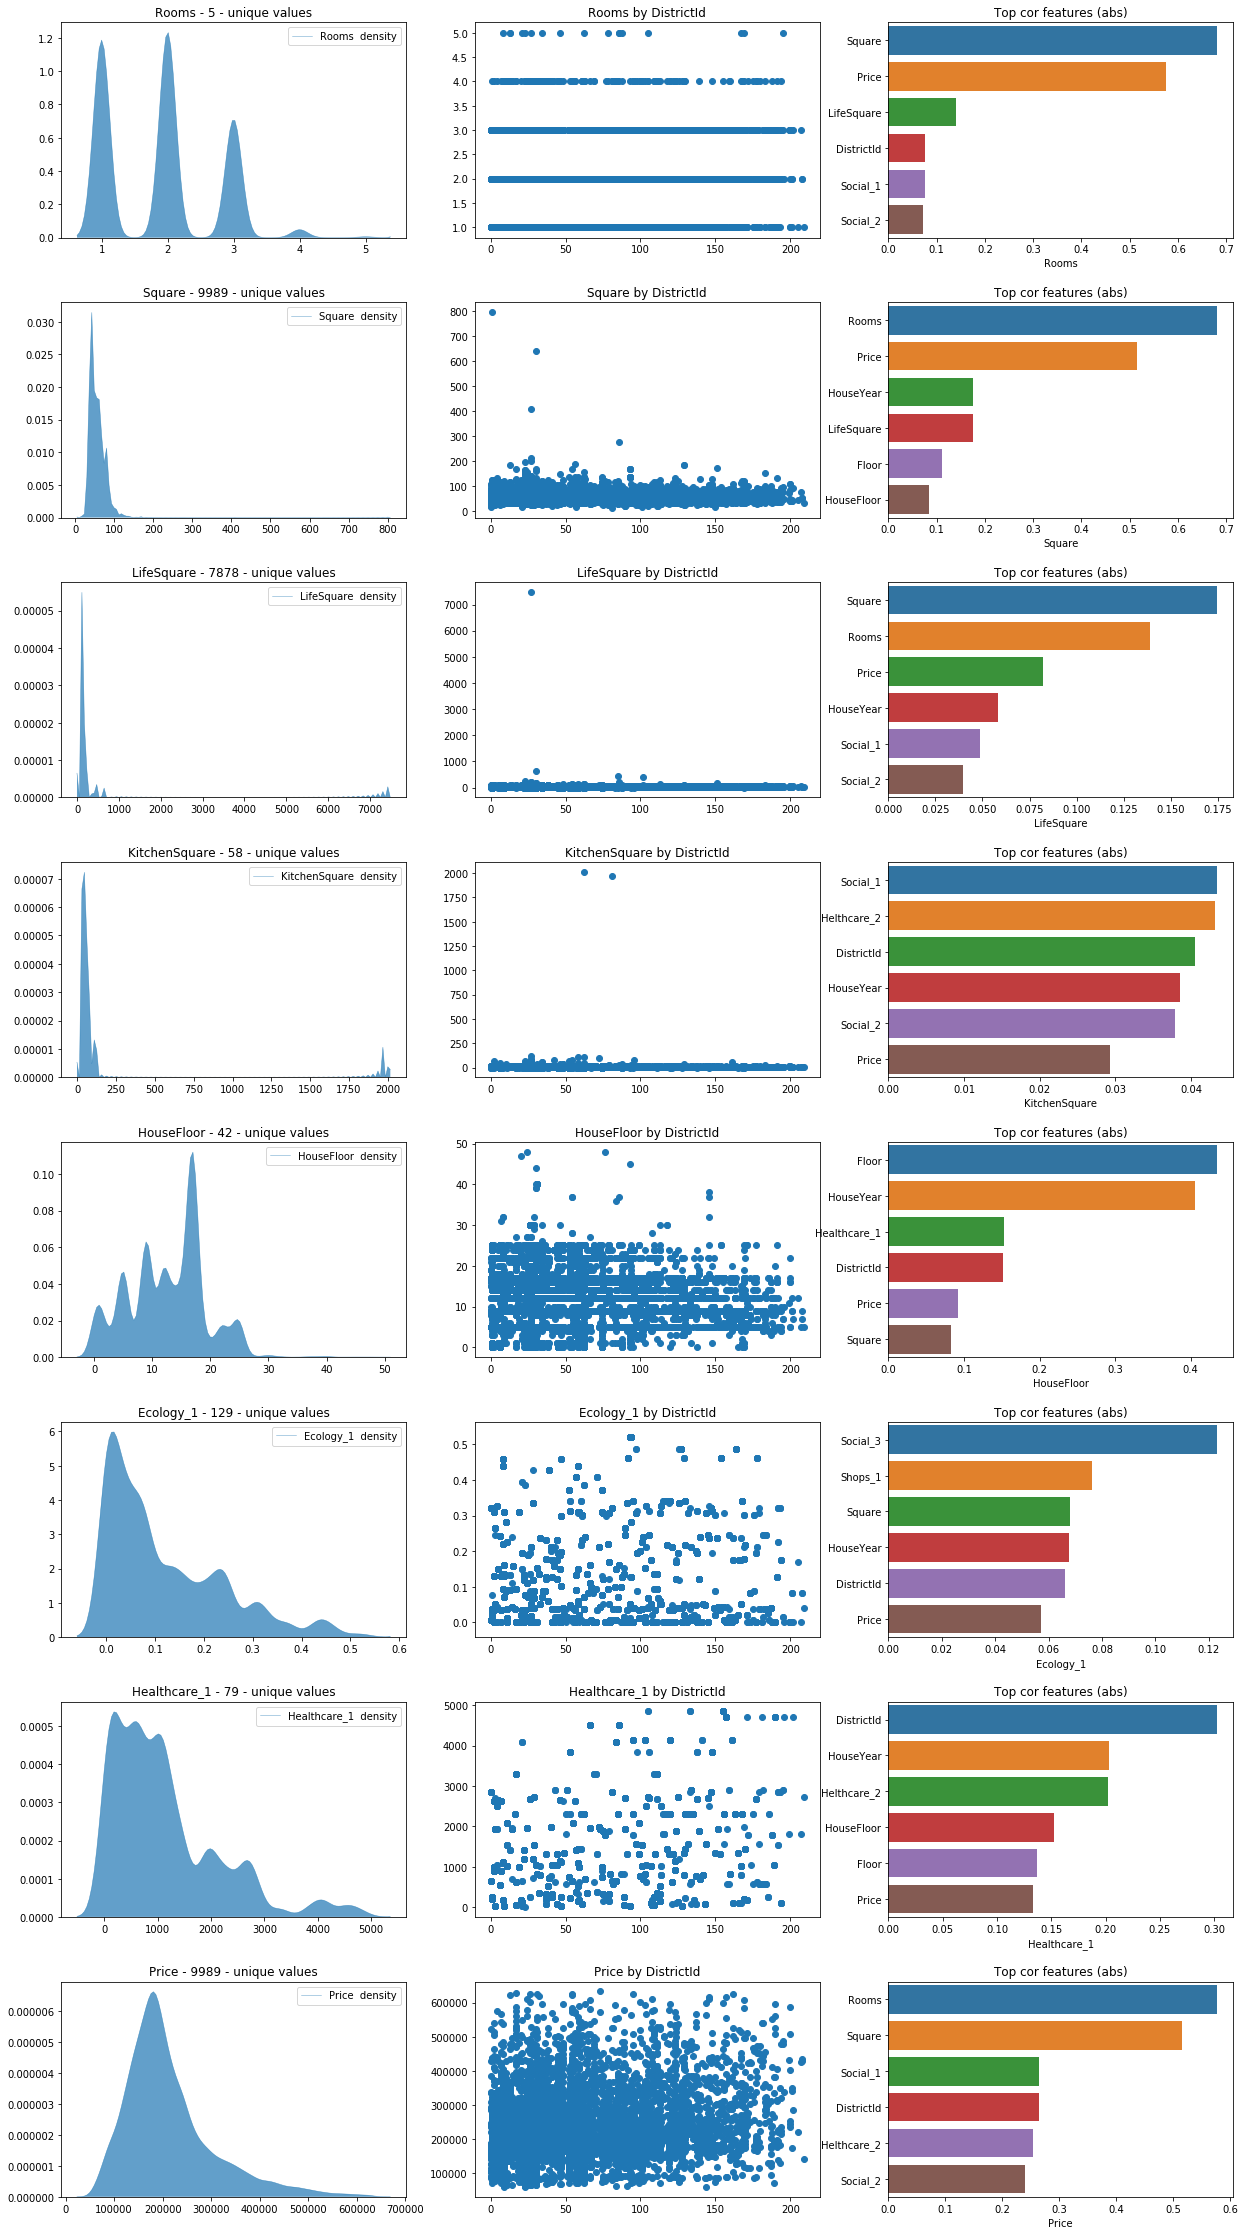

In [19]:
# Визуальный анализ распределения данных
#1) Вывод плотности распределения, 
#2) оценка среднего значения с уровнем значимости 0.05
#3) Скорелированные факторы
distribution_comparison_by_target_class(df, TARGET_NAME='DistrictId', model_type='regression')

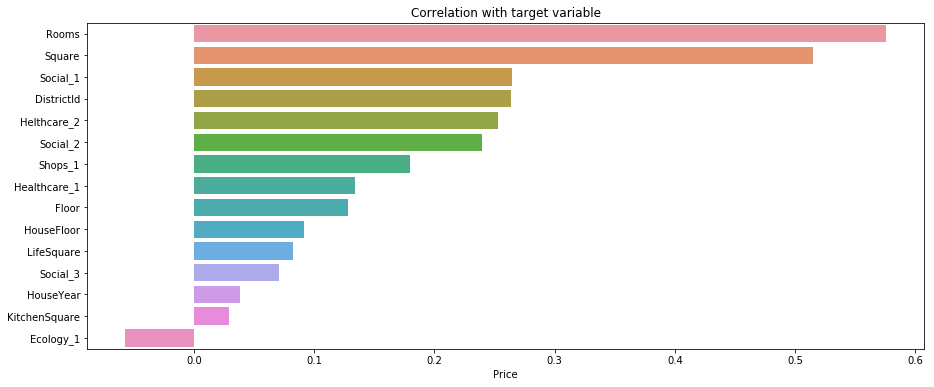

In [20]:
#Кореляция факторов с целевой переменной
cor = df.corr().iloc[:-1,-1].sort_values(ascending=False)

plt.figure(figsize=(15, cor.shape[0] * 0.4))
sns.barplot(x=cor, y=cor.index)
plt.title('Correlation with target variable')
plt.show();

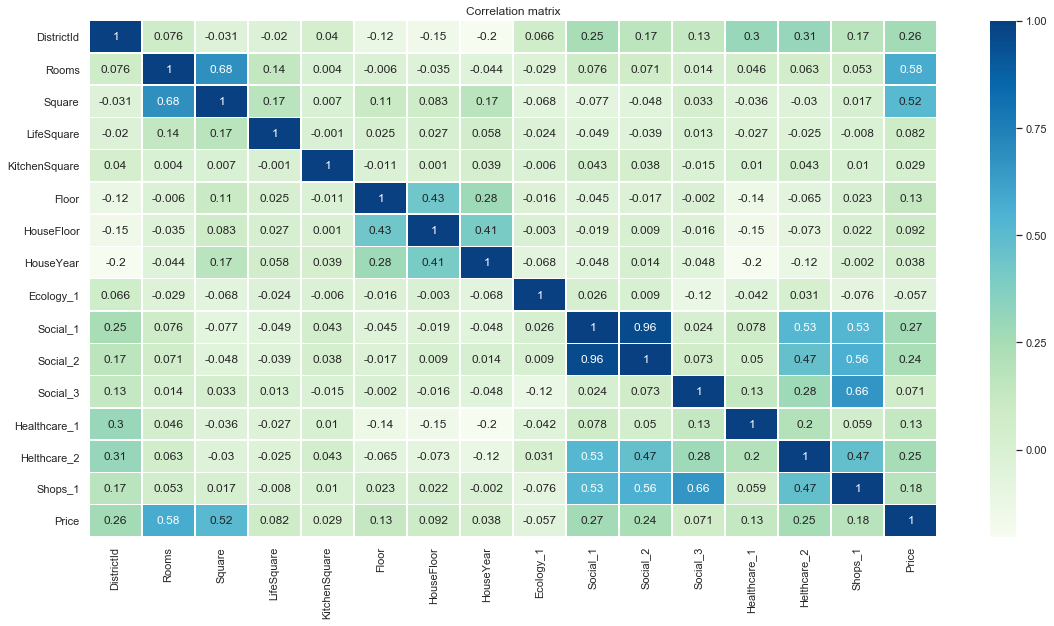

In [21]:
#Матрица Корреляции факторов
heatmap(df)

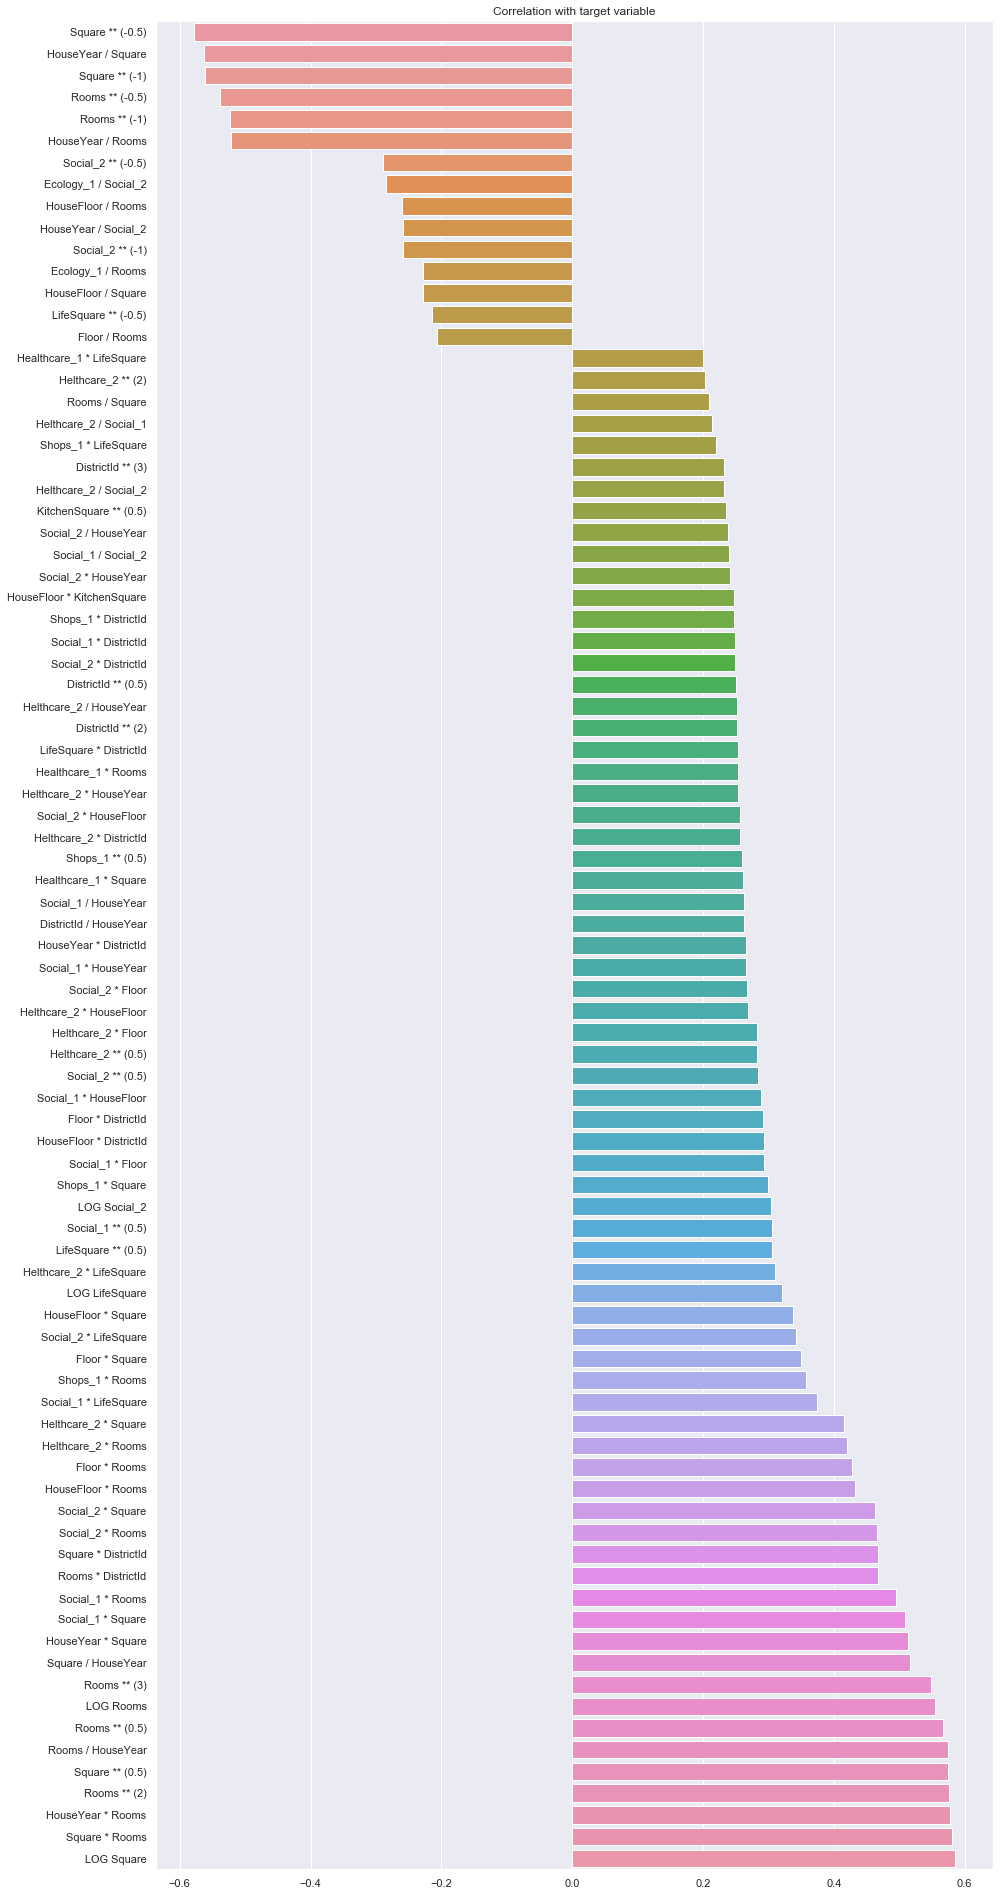

In [22]:
#Вывод наиболее скоррелированных с целевой переменной комбинаций признаков (умножение, деление, степень) 
df1, df1_test = feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.2, hi_limit = 0.2, plot_cor=True, powers=[-1, -0.5, 0.5, 2, 3])

# Создание и валидация моделей

In [23]:
%%time

#import xgboost as xgb, lightgbm as lgbm, catboost as catb


# подготовка моделей
catbm = catb.CatBoostRegressor(eval_metric='R2',
                                     silent=True,
                                     random_state=21)

coefs = np.ones(501)
gb = GradientBoosting(eta=0.2, n_estimators=400, min_data_in_leaf=40, max_depth=4, random_state=42, model_type='regression', split_points=5, coefs=coefs)

rfm = RandomForestRegressor(n_estimators=500, min_samples_leaf=20, max_depth=12, random_state=42)


models = {'catbm':catbm, 'gb':gb}

# Расчет показателей моделей для случая с дополнительными переменными (метрики лучше)
df_result, df_test_result, model_list = check_models(df=df,
                                                   df_test=df_test,
                                                   TARGET_NAME=TARGET_NAME,
                                                   models=models,                                                     
                                                   target_class_ratio=0.50,
                                                   random_state=42,
                                                   SKF_splits=5,
                                                   fold_report=True,
                                                   train_report=False,
                                                   data_pr=True,
                                                   scaler_type='std',
                                                   model_type='regression')


FOLD 1 REPORT
Model                        MAE             RMSE               R2
catbm_1_valid          27813.807       46059.7626           0.7471
                                                                                                                                                                                                                                                                                                              gb_1_valid            28771.4867       46381.7852           0.7435

FOLD 2 REPORT
Model                        MAE             RMSE               R2
catbm_2_valid          27392.603       44175.9304           0.7674
                                                                                                                                                                                                                                                                                                               245      Cur MSE: 45279.322 45

In [24]:
df_test_result

,index,catbm,catbm_p,gb,gb_p
0,725,169010.711507,0.0,144886.142969,0.0
1,15856,214059.408932,0.0,217260.372351,0.0
2,5480,249545.907976,0.0,225680.072127,0.0
3,15664,350749.674174,0.0,346415.429223,0.0
4,14275,132812.842969,0.0,143115.416988,0.0
...,...,...,...,...,...
4995,8180,241774.988991,0.0,232853.730252,0.0
4996,4695,130773.089239,0.0,136209.584917,0.0
4997,5783,335418.726722,0.0,320626.852116,0.0
4998,4780,196622.966928,0.0,186660.654944,0.0


In [25]:
# Список столбоц в отчете df_test_result которые необходимо вывести в качестве предсказания
predict_cols = [1,3]
# Расчет усредненного предсказания вероятности по всем моделям
y_test_pred = np.sum(df_test_result.iloc[:, predict_cols], axis=1) / len(predict_cols)

pd.DataFrame({'Id': df_test_result['index'],
              TARGET_NAME: y_test_pred}).to_csv(sub_repot_path, index=False)

print('\nЗапись в файл:', sub_repot_path, '\n')


Запись в файл: D:/Personal/Lesha/Data Science & AI/kaggle/Competitions/Real Estate Price Prediction/Ushakov_submission_re_price_prediction.csv 



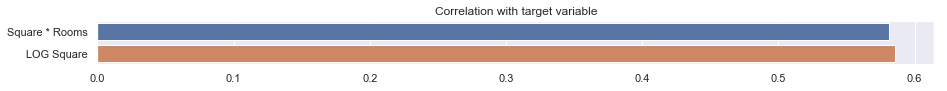


FOLD 1 REPORT
Model                        MAE             RMSE               R2
catbm_1_valid         27903.8439       46149.1305           0.7461
                                                                                                                                                                                                                                                                                                              gb_1_valid            28880.5525       46795.2838           0.7389

FOLD 2 REPORT
Model                        MAE             RMSE               R2
catbm_2_valid         27579.5437       44419.5506           0.7648
                                                                                                                                                                                                                                                                                                              gb_2_valid            28466.352

In [28]:
%%time

# подготовка моделей
catbm = catb.CatBoostRegressor(eval_metric='R2',
                                     silent=True,
                                     random_state=21)
coefs = np.ones(501)
gb = GradientBoosting(eta=0.2, n_estimators=400, min_data_in_leaf=40, max_depth=4, random_state=42, model_type='regression', split_points=5, coefs=coefs)

rfm = RandomForestRegressor(n_estimators=500, min_samples_leaf=20, max_depth=12, random_state=42)

models = {'catbm':catbm, 'gb':gb}

#Добавление к исходному массиву наиболее скоррелированного признака - улучшает качество модели
df1, df1_test = feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.6, hi_limit = 0.58, plot_cor=True, powers=[])

# Расчет показателей модели для случая с дополнительными переменными (метрики лучше)
df1_result, df1_test_result, model_list_1 = check_models(df=df1,
                                                   df_test=df1_test,
                                                   TARGET_NAME=TARGET_NAME,
                                                   models = models,
                                                   target_class_ratio=0.50,
                                                   random_state=42,
                                                   SKF_splits=5,
                                                   fold_report=True,
                                                   train_report=False,
                                                   data_pr=True,
                                                   scaler_type='std',
                                                   strat_layers_qty=10,
                                                   model_type='regression')

In [29]:
# Список столбоц в отчете df_test_result которые необходимо вывести в качестве предсказания
predict_cols = [1,3]
# Расчет усредненного предсказания вероятности по всем моделям
y_test_pred = np.sum(df1_test_result.iloc[:, predict_cols], axis=1) / len(predict_cols)

pd.DataFrame({'Id': df1_test_result['index'],
              TARGET_NAME: y_test_pred}).to_csv(sub_repot_path, index=False)

print('\nЗапись в файл:', sub_repot_path, '\n')


Запись в файл: D:/Personal/Lesha/Data Science & AI/kaggle/Competitions/Real Estate Price Prediction/Ushakov_submission_re_price_prediction.csv 



# Вывод предсказний в файл

In [ ]:
# Список столбоц в отчете df_test_result которые необходимо вывести в качестве предсказания
predict_cols = [1]
# Расчет усредненного предсказания вероятности по всем моделям
y_test_pred = np.sum(df1_test_result.iloc[:, predict_cols], axis=1)

pd.DataFrame({'Id': df1_test_result['index'],
              TARGET_NAME: y_test_pred}).to_csv(sub_repot_path, index=False)

print('\nЗапись в файл:', sub_repot_path, '\n')